In [2]:
import pandas as pd
import datetime as dt

In [3]:
import os, sys

In [4]:
sys.path.append('/Users/oisin-brogan/Code/step_suggestions/')
import rules

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
suggestions = []

for root, dirs, files in os.walk('/Users/oisin-brogan/Downloads/moderated_photos/suggestions_15/'):
    if not dirs:
        user = root.split('/')[-2]
        with open(root + '/image_list.txt') as f:
            s = f.readlines()
            s = [[i[:-5]] for i in s]
            suggestions.append([user, s])
suggestions = pd.DataFrame(suggestions, columns=['user', 'suggestion'])

In [7]:
suggestions.loc[suggestions.user == '2432003']['suggestion'][0]

[['525a210a34a26731'],
 ['88174425f39231e5'],
 ['b2f205ecbb4aba18'],
 ['becff6418f0ed6ee'],
 ['9a23b48c63a4520e'],
 ['f7f3f95cdfd138af'],
 ['f856980437738c71'],
 ['d40e4165162ebf7d']]

In [8]:
c_m_photos_db = pd.read_csv('/Users/oisin-brogan/Downloads/moderated_photos/db.csv')
c_m_photos_db.taken_at = c_m_photos_db.taken_at.map(rules.convert_ckpd_to_datetime)

In [9]:
cm_users = set(c_m_photos_db.user_id)

In [10]:
def parse_label(fldr_path):
    with open(fldr_path + 'label.txt', 'r') as f:
        recipe = f.readline()
        if recipe == 'recipe\n':
            lines = f.readlines()
        else:
            lines = []
    
    lines = [l.strip() for l in lines]
    indexs = [i for i,v in enumerate(lines) if v.startswith('.')]
    indexs.append(len(lines))
    list_of_recipes = [lines[indexs[i]+1:indexs[i+1]] for i in range(len(indexs)-1)]
                       
    return list_of_recipes

In [11]:
all_recipes = {}

for user_id in cm_users:
    usr_fldr = '/Users/oisin-brogan/Downloads/moderated_photos/by_user/' + str(user_id) + '/'
    recipes = parse_label(usr_fldr)
    all_recipes[usr_fldr.split('/')[-2]] = recipes

total_recipes = sum([len(v) for v in all_recipes.values()])

In [12]:
for i, row in suggestions.iterrows():
    extra_photos, suff_cover = rules.is_suggestion_recipe(row['suggestion'], all_recipes[row['user']] )
    suggestions.loc[i, 'extra_photos'] = extra_photos
    suggestions.loc[i, 'suff_cover'] = suff_cover
    suggestions.loc[i, 'recipe_or_not'] = extra_photos and suff_cover

total_suggestions = suggestions.shape[0]
total_recipe_finds = suggestions[suggestions.recipe_or_not].shape[0]
precision = total_recipe_finds/float(total_suggestions)
recall = total_recipe_finds/float(total_recipes)

In [13]:
precision

0.48

In [14]:
recall

0.4878048780487805

In [15]:
#Build suggestion timeline
def time_of_suggestion(suggestion, df_image_index):
    images = rules.suggestions_with_dup_groups_to_flat(suggestion)
    times = df.loc[images].taken_at
    suggestion_time = max(times)
    
    return suggestion_time

In [16]:
df = c_m_photos_db.copy()
df = df.set_index('image_id')

suggestions['time_of_suggestion'] = suggestions.suggestion.apply(time_of_suggestion, args=(df,))

In [17]:
def create_timeline(sugg_df):
    all_timelines = []

    g = sugg_df.groupby('user')
    for user, dataframe in g:
        t = dataframe.time_of_suggestion.values
        timeline = pd.Series([1]*len(t), index = t, name=user)
        timeline = timeline.resample('D').sum()
        all_timelines.append(timeline)

    all_timeline = pd.concat(all_timelines, axis = 1)
    
    return all_timeline

In [18]:
all_timeline = create_timeline(suggestions)

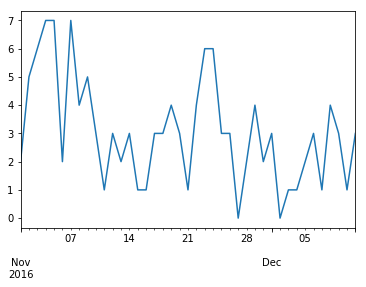

In [19]:
all_timeline.sum(axis=1).plot()

In [20]:
tp_timeline = create_timeline(suggestions[suggestions.recipe_or_not])

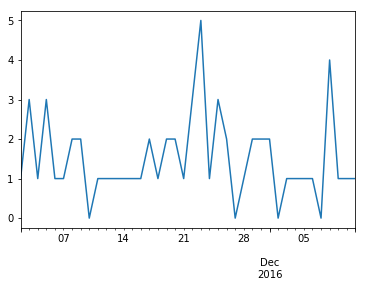

In [21]:
tp_timeline.sum(axis=1).plot()

In [22]:
error_timeline = create_timeline(suggestions[suggestions.recipe_or_not.apply(lambda x: not x)])

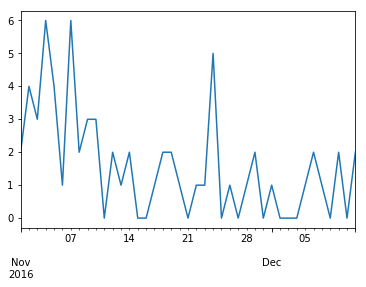

In [23]:
error_timeline.sum(axis=1).plot()

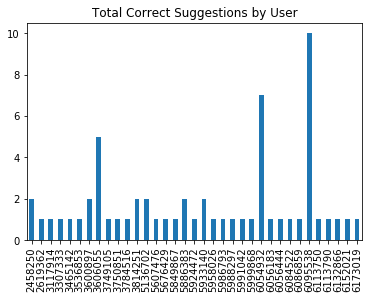

In [64]:
tp_timeline.sum().plot(kind='bar', title = 'Total Correct Suggestions by User')

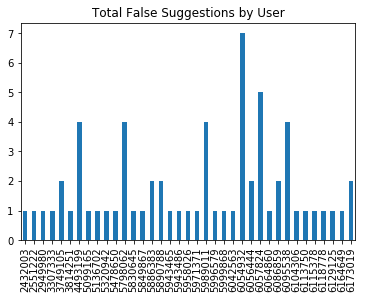

In [63]:
error_timeline.sum().plot(kind='bar', title = 'Total False Suggestions by User')

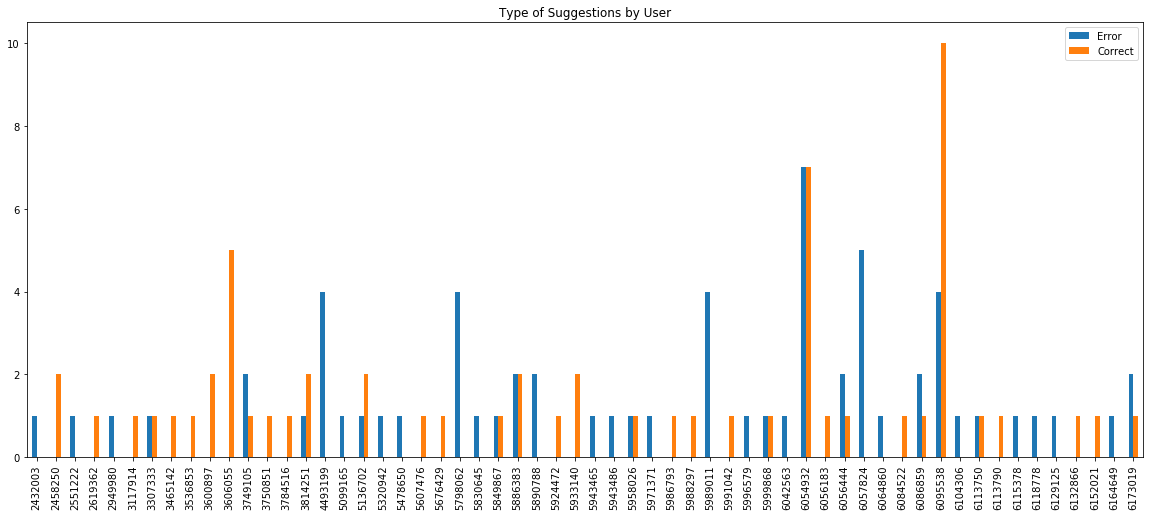

In [67]:
errors_and_pos = pd.concat([error_timeline.sum(), tp_timeline.sum()], axis=1)
errors_and_pos.columns = ['Error', 'Correct']
errors_and_pos.plot(kind='bar', figsize=[20,8], title = 'Type of Suggestions by User')

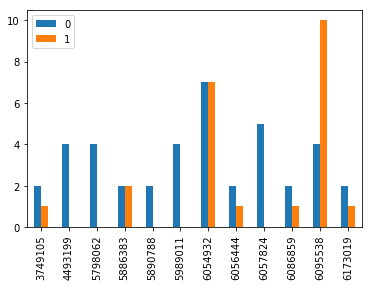

In [33]:
errors_and_pos = pd.concat([error_timeline.sum(), tp_timeline.sum()], axis=1)
errors_and_pos[errors_and_pos[0] > 1].plot(kind='bar')

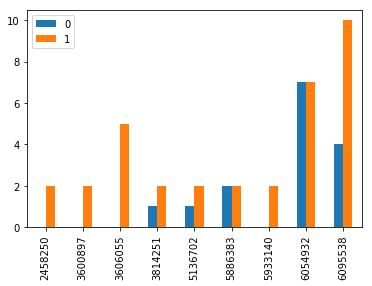

In [27]:
errors_and_pos[errors_and_pos[1] > 1].plot(kind='bar')

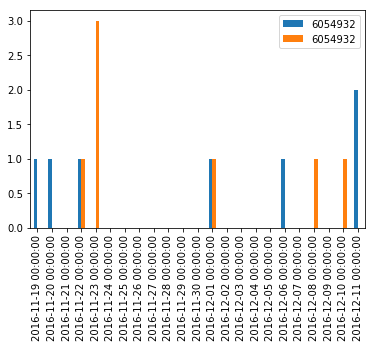

In [61]:
pd.concat([error_timeline['6054932'], tp_timeline['6054932']],axis=1)['2016-11-19':].plot(kind='bar')

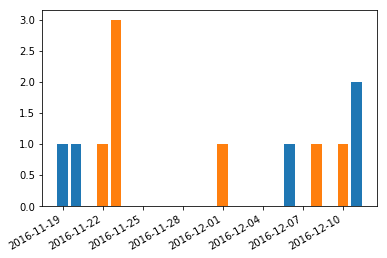

In [58]:
test = pd.concat([tp_timeline['6054932'], error_timeline['6054932']],axis=1) 
test.columns = [0,1]

fig, ax = plt.subplots(1)
ax.bar(test.index, test[1])
ax.bar(test.index, test[0])

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# use a more precise date string for the x axis locations in the
# toolbar
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')